In [106]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft2, ifft2, fftshift
from joblib import Parallel, delayed
import PIL
import cupy as cp
from ttictoc import tic, toc 
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter  
from skimage import io


def hsv2rgb(hsv, *, channel_axis=-1):
    
    arr = hsv

    hi = np.floor(arr[..., 0] * 6)
    f = arr[..., 0] * 6 - hi
    p = arr[..., 2] * (1 - arr[..., 1])
    q = arr[..., 2] * (1 - f * arr[..., 1])
    t = arr[..., 2] * (1 - (1 - f) * arr[..., 1])
    v = arr[..., 2]

    hi = np.stack([hi, hi, hi], axis=-1).astype(np.uint8) % 6
    out = np.choose(
        hi, np.stack([np.stack((v, t, p), axis=-1),
                      np.stack((q, v, p), axis=-1),
                      np.stack((p, v, t), axis=-1),
                      np.stack((p, q, v), axis=-1),
                      np.stack((t, p, v), axis=-1),
                      np.stack((v, p, q), axis=-1)]))

    return out

def hsv2rgb_cu(hsv, *, channel_axis=-1):
    
    arr = hsv

    hi = cp.floor(arr[..., 0] * 6)
    f = arr[..., 0] * 6 - hi
    p = arr[..., 2] * (1 - arr[..., 1])
    q = arr[..., 2] * (1 - f * arr[..., 1])
    t = arr[..., 2] * (1 - (1 - f) * arr[..., 1])
    v = arr[..., 2]

    hi = cp.stack([hi, hi, hi], axis=-1).astype(np.uint8) % 6
    out = cp.choose(
        hi, cp.stack([cp.stack((v, t, p), axis=-1),
                      cp.stack((q, v, p), axis=-1),
                      cp.stack((p, v, t), axis=-1),
                      cp.stack((p, q, v), axis=-1),
                      cp.stack((t, p, v), axis=-1),
                      cp.stack((v, p, q), axis=-1)]))
    out = cp.asnumpy(out)
    return out

#creates the colohweel
def bldclrwhl(nx, ny, sym):
    da = np.ones((nx,ny,2))
    x = np.linspace(-nx/2,nx/2,nx)
    y = np.linspace(-ny/2,ny/2,ny)
    xx, yy = np.meshgrid(y,x)
    zz = (((np.arctan2(xx, yy) / math.pi) + 1.0) / 2.0)*sym
    d2 = np.dstack((zz, da))
    imnp = np.array(hsv2rgb(d2))
    return imnp

''' #creates the colohweel
def bldclrwhl_cu(nx, ny, sym):
    cda = cp.ones((nx,ny,2))
    cx = cp.linspace(-nx/2,nx/2,nx)
    cy = cp.linspace(-ny/2,ny/2,ny)
    cxx, cyy = cp.meshgrid(cy,cx)
    czz =(((cp.arctan2(cxx, cyy) / math.pi) + 1.0) / 2.0)*sym
    cd2 = cp.dstack((czz, cda))
    d2 = cp.asnumpy(cd2)
    imnp = np.array(hsv2rgb(d2))
    return imnp '''


#creates the colohweel
def bldclrwhl_cu_big(nx, ny, sym):
    tic()
    cda = cp.ones((nx, ny,2))
    cx = cp.linspace(-nx,nx,nx)
    cy = cp.linspace(-ny,ny,ny)
    cxx, cyy = cp.meshgrid(cy,cx)
    czz =(((cp.arctan2(cxx, cyy) / math.pi) + 1.0) / 2.0)*sym
    cd2 = cp.dstack((czz, cda))
    carr = cd2
    chi = cp.floor(carr[..., 0] * 6)
    f = carr[..., 0] * 6 - chi
    p = carr[..., 2] * (1 - carr[..., 1])
    q = carr[..., 2] * (1 - f * carr[..., 1])
    t = carr[..., 2] * (1 - (1 - f) * carr[..., 1])
    v = carr[..., 2]
    chi = cp.stack([chi, chi, chi], axis=-1).astype(cp.uint8) % 6
    out = cp.choose(
        chi, cp.stack([cp.stack((v, t, p), axis=-1),
                      cp.stack((q, v, p), axis=-1),
                      cp.stack((p, v, t), axis=-1),
                      cp.stack((p, q, v), axis=-1),
                      cp.stack((t, p, v), axis=-1),
                      cp.stack((v, p, q), axis=-1)]))
    imnp = cp.asnumpy(out)
    print(toc())
    return imnp

def nofft(whl, img, nx, ny):
    imnp = np.array(img)
    fimg = fft2(imnp)
    whl = fftshift(whl)
    proimg = np.zeros((nx,ny,3))
    comb = np.zeros((nx,ny,3), dtype=complex)
    magnitude = np.repeat(np.abs(fimg)[:,:,np.newaxis], 3, axis=2)
    phase = np.repeat(np.angle(fimg)[:,:,np.newaxis], 3, axis=2)
    proimg = whl*magnitude
    comb = np.multiply(proimg, np.exp(1j*phase))
    for n in range(3):
        proimg[:, :, n] = np.real(ifft2(comb[:,:,n]))
        proimg[:, :, n] = proimg[:, :, n] - np.min(proimg[:, :, n])
        proimg[:, :, n] = proimg[:, :, n] / np.max(proimg[:, :, n])
    return proimg    

def nofft_cu(whl, img, nx, ny):
    imnp = cp.array(img)
    fimg = cp.fft.fft2(imnp)
    whl  = cp.fft.fftshift(whl)
    proimg = cp.zeros((nx,ny,3))
    comb = cp.zeros((nx,ny,3), dtype=complex)
    magnitude = cp.repeat(np.abs(fimg)[:,:,np.newaxis], 3, axis=2)
    phase = cp.repeat(np.angle(fimg)[:,:,np.newaxis], 3, axis=2)
    proimg = whl*magnitude
    comb = cp.multiply(proimg, cp.exp(1j*phase))
    for n in range(3):
        proimg[:, :, n] = cp.real(cp.fft.ifft2(comb[:,:,n]))
        proimg[:, :, n] = proimg[:, :, n] - cp.min(proimg[:, :, n])
        proimg[:, :, n] = proimg[:, :, n] / cp.max(proimg[:, :, n])
            
    proimg = cp.asnumpy(proimg)
    return proimg

In [97]:
#Read Image
data = Image.open('./data/block_2.tif')
data = np.array(data)[:,:]
print(data.shape)
symmetry = 6


(1890, 1962)


0.8661195550012053


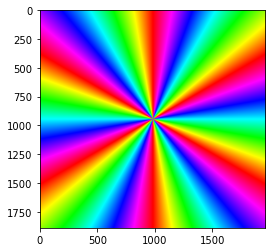

1.3558463599983952


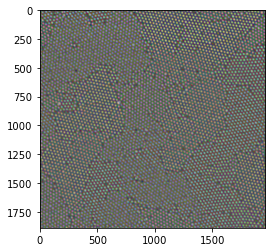

0.2637109489951399


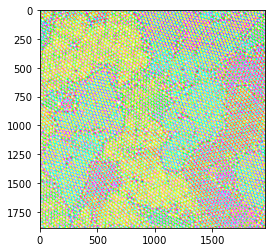

In [105]:

tic()
clrwhl = bldclrwhl(data.shape[0], data.shape[1],symmetry)
print(toc())
plt.imshow(clrwhl)
plt.show()

tic()
imnp = nofft(clrwhl, data, data.shape[0], data.shape[1])
print(toc())
plt.imshow(imnp)
plt.show()
tic()
imnp = imnp-np.min(imnp)
imnp = imnp/np.max(imnp)*255
rgb2 = Image.fromarray(np.uint8(imnp))
img2 = rgb2.filter(ImageFilter.GaussianBlur(radius = 0.0)) 
converter = PIL.ImageEnhance.Color(img2)
img2 = converter.enhance(3.2)
converter = PIL.ImageEnhance.Brightness(img2)
img2 = converter.enhance(2.2)
converter = PIL.ImageEnhance.Contrast(img2)
img2 = converter.enhance(1.0)
print(toc())
plt.imshow(img2)
plt.show() 

0.07712352699309122


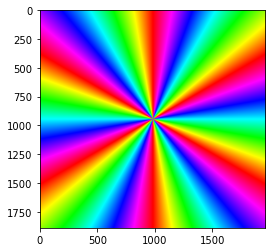

0.11512455299816793


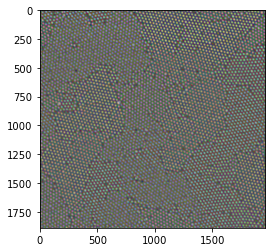

0.2584163930005161


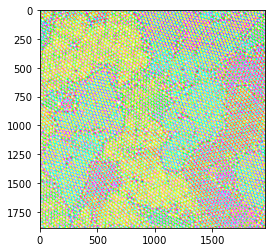

In [108]:

clrwhl = bldclrwhl_cu_big(data.shape[0], data.shape[1],symmetry)

plt.imshow(clrwhl)
plt.show()
 
tic()
imnp = nofft_cu(clrwhl, data, data.shape[0], data.shape[1])
print(toc())
plt.imshow(imnp)
plt.show() 
tic()
imnp = imnp-np.min(imnp)
imnp = imnp/np.max(imnp)*255
rgb2 = Image.fromarray(np.uint8(imnp))
img2 = rgb2.filter(ImageFilter.GaussianBlur(radius = 0.0)) 
converter = PIL.ImageEnhance.Color(img2)
img2 = converter.enhance(3.2)
converter = PIL.ImageEnhance.Brightness(img2)
img2 = converter.enhance(2.2)
converter = PIL.ImageEnhance.Contrast(img2)
img2 = converter.enhance(1.0)
print(toc())
plt.imshow(img2)
plt.show() 

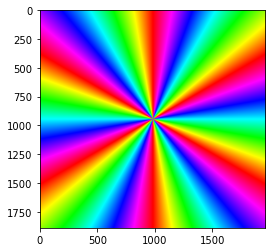

In [91]:
tt = np.array(hsv(ssss))
plt.imshow(tt)

In [68]:
#creates the colohweel
def test(nx, ny, sym):
    tic()
    cda = cp.ones((nx, ny,2))
    cx = cp.linspace(-nx,nx,nx)
    cy = cp.linspace(-ny,ny,ny)
    cxx, cyy = cp.meshgrid(cy,cx)
    czz =(((cp.arctan2(cxx, cyy) / math.pi) + 1.0) / 2.0)*sym
    cd2 = cp.dstack((czz, cda))
    d2 = cp.asnumpy(cd2)
    print(toc())
    tic()
    imnp = np.array(hsv2rgb(d2))
    print(toc())
    return d2

In [69]:
ssss = test(data.shape[0], data.shape[1],symmetry)

0.040824852003424894
0.7646085660016979


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


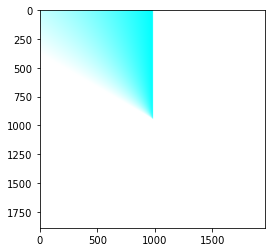

In [71]:
plt.imshow(ssss)